In [7]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [8]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the iedfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [9]:
from iexfinance.stocks import get_historical_data
from iexfinance.refdata import get_symbols
import iexfinance as iex

key = os.getenv("IEX_TOKEN")
type(key)


str

# Data Collection

In this step, you will need to use the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [10]:


list_of_tickers = ["SPY", "AGG"]

end_date = datetime.now()
start_date = end_date + timedelta(-1825)

# Get 5 year's worth of historical data for `SPY` and `AGG`
df = get_historical_data(list_of_tickers, start_date, end_date,  output_format='pandas')
df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
df.head()

,SPY,AGG
,close,close
date,,
2014-10-02,194.38,109.35
2014-10-03,196.52,109.30
2014-10-06,196.29,109.40
2014-10-07,193.26,109.82
2014-10-08,196.64,110.13


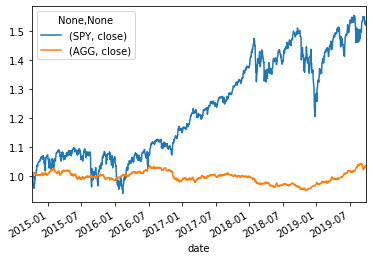

In [11]:
daily_change_original = df.pct_change()
cum_return = (1+daily_change_original).cumprod()
cum_return.tail()

cum_return.plot()

# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 100 iterations and generate at least 20 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 20 years

In [12]:
# Calculate the daily roi for the stocks
daily_returns = df.pct_change()
daily_returns.tail()

,SPY,AGG
,close,close
date,,
2019-09-24,-0.007847,0.002744
2019-09-25,0.005915,-0.004149
2019-09-26,-0.002083,0.001684
2019-09-27,-0.005387,0.001239
2019-09-30,0.004638,0.000265


In [13]:
avg_daily_return_spy = daily_returns.mean()['SPY']['close']
avg_daily_return_agg = daily_returns.mean()['AGG']['close']
avg_daily_return_spy

0.00037427732410179814

In [14]:
# Calculate volatility
std_dev_daily_return_spy = daily_returns.std()['SPY']['close']
std_dev_daily_return_agg = daily_returns.std()['AGG']['close']
std_dev_daily_return_agg

0.00203174691041178

In [15]:
# Save the last day's closing price
spy_last_price = df['SPY']['close'][-1]
agg_last_price = df['AGG']['close'][-1]

In [16]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [17]:
# Run the Monte Carlo Simulation
for n in range(number_simulations):
    
    sim_price_list_spy = [spy_last_price]
    sim_price_list_agg = [agg_last_price]
    
    for i in range(number_records):
        
        sim_price_result_spy = sim_price_list_spy[-1] * (1 + np.random.normal(avg_daily_return_spy,std_dev_daily_return_spy))
        sim_price_result_agg = sim_price_list_agg[-1] * (1 + np.random.normal(avg_daily_return_agg,std_dev_daily_return_agg))
        
        sim_price_list_spy.append(sim_price_result_spy)
        sim_price_list_agg.append(sim_price_result_agg)
    
    monte_carlo["SPY prices"] = pd.Series(sim_price_list_spy)
    monte_carlo["AGG prices"] = pd.Series(sim_price_list_agg)
    
    simulated_daily_returns = monte_carlo.pct_change()

    weights = [0.60, 0.40]
    
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

portfolio_cumulative_returns.tail()


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
7556,6.364699,5.034122,7.063802,7.681403,6.901422,5.258432,6.642446,10.796538,7.119201,7.784339,...,1.907372,7.529529,4.185424,6.953119,8.632365,9.694398,2.483544,5.953658,11.784051,2.620126
7557,6.352853,5.052715,7.080875,7.672488,6.844263,5.252639,6.603162,10.860664,7.075030,7.771321,...,1.889507,7.523036,4.175303,6.977302,8.625421,9.754981,2.508315,5.952940,11.901728,2.602907
7558,6.320411,5.052606,7.146453,7.675060,6.863675,5.257780,6.617882,10.873186,7.124385,7.738899,...,1.887254,7.562521,4.176173,7.002572,8.675898,9.717215,2.505185,5.909495,11.982815,2.588311
7559,6.307919,5.087242,7.170189,7.680668,6.856408,5.284284,6.615344,10.840404,7.133742,7.705401,...,1.899235,7.596686,4.137809,6.946822,8.688692,9.680317,2.532887,5.901109,12.024990,2.587505
7560,6.298663,5.105867,7.224299,7.683280,6.873958,5.294948,6.606322,10.782401,7.124074,7.701149,...,1.900810,7.637136,4.116556,7.008355,8.694486,9.684851,2.521088,5.851976,11.925462,2.591350


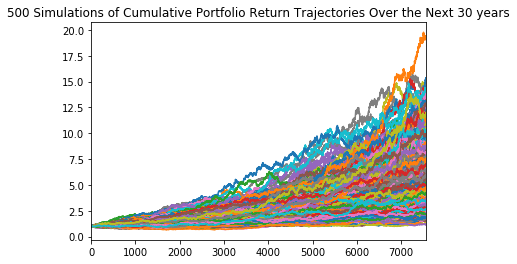

In [18]:
# Visualize the Simulation

plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 30 years"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [19]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.tail()

495     9.684851
496     2.521088
497     5.851976
498    11.925462
499     2.591350
Name: 7560, dtype: float64

In [20]:
# Select the last row for the cumulative returns (cumulative returns at 20 years), 252*20=5040
ending_cumulative_returns_20 = portfolio_cumulative_returns.iloc[5040, :]
ending_cumulative_returns_20.tail()

495    4.554370
496    1.705706
497    3.481869
498    4.659312
499    2.418660
Name: 5040, dtype: float64

In [21]:
# Display the 90% confidence interval for the ending returns
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

0.05     2.428359
0.95    11.036749
Name: 7560, dtype: float64

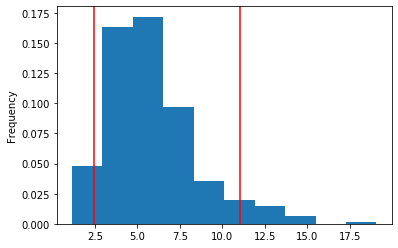

In [22]:
# Visualize the distribution of the ending returns
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [23]:
cum_returns_10 = np.percentile(ending_cumulative_returns,10)
cum_returns_50 = np.percentile(ending_cumulative_returns,50)
cum_returns_90 = np.percentile(ending_cumulative_returns,90)

print(f"The cumulative returns at the 10th percentile: {cum_returns_10}, at the 50th percentile: {cum_returns_50}, and at the 90th percentile: {cum_returns_90}")

The cumulative returns at the 10th percentile: 3.0666667033202897, at the 50th percentile: 5.236916111888476, and at the 90th percentile: 9.134391873268179


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [24]:
initial_investment = 20000

portfolio_return_10 = initial_investment + (initial_investment * cum_returns_10)

portfolio_return_50 = initial_investment + (initial_investment * cum_returns_50)

portfolio_return_90 = initial_investment + (initial_investment * cum_returns_90)


print(f"Given an initial investment of ${initial_investment}, the expected portfolio return in dollars at the 10th percentile: ${portfolio_return_10}, at the 50th percentile ${portfolio_return_50}, and at the 90th percentile: ${portfolio_return_90}")

Given an initial investment of $20000, the expected portfolio return in dollars at the 10th percentile: $81333.33406640579, at the 50th percentile $124738.32223776952, and at the 90th percentile: $202687.83746536358


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [25]:
withdraw = portfolio_return_10 * 0.04
withdraw

print(f"A 4% withdraw rate from the retirement portfolio at the 10th percentile is: ${withdraw}, that does not exceed the projected annual income of $6085")

A 4% withdraw rate from the retirement portfolio at the 10th percentile is: $3253.3333626562317, that does not exceed the projected annual income of $6085


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [30]:
initial_investment_increase = 50000

portfolio_return_10_increase = initial_investment_increase + (initial_investment_increase * cum_returns_10)

portfolio_return_50_increase = initial_investment_increase + (initial_investment_increase * cum_returns_50)

portfolio_return_90_increase = initial_investment_increase + (initial_investment_increase * cum_returns_90)

withdraw_increase = portfolio_return_10_increase * 0.04
withdraw_increase

print(f"Given an initial investment of ${initial_investment_increase}, the expected portfolio return in dollars at the 10th percentile: ${portfolio_return_10_increase}, at the 50th percentile ${portfolio_return_50_increase}, and at the 90th percentile: ${portfolio_return_90_increase}")
print("\n")
print(f"A 4% withdraw rate from the retirement portfolio at the 10th percentile with a ${initial_investment_increase} initial investment is: ${withdraw_increase} and that does not exceed the projected annual income of $6085")


Given an initial investment of $50000, the expected portfolio return in dollars at the 10th percentile: $203333.3351660145, at the 50th percentile $311845.8055944238, and at the 90th percentile: $506719.59366340894


A 4% withdraw rate from the retirement portfolio at the 10th percentile with a $50000 initial investment is: $8133.3334066405805 and that does not exceed the projected annual income of $6085


### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [455]:
#for i in portfolio_cumulative_returns.iloc[i]
initial_investment = 50000
nintey_five = []
fifty = []
five = []

nintey_five_df = pd.DataFrame() 
fifty_df = pd.DataFrame() 
five_df = pd.DataFrame() 


for i in range(len(portfolio_cumulative_returns)):

    test_1 = (np.percentile(portfolio_cumulative_returns.iloc[i],95) * initial_investment)
    test_2 = (np.percentile(portfolio_cumulative_returns.iloc[i],50) * initial_investment)
    test_3 = (np.percentile(portfolio_cumulative_returns.iloc[i],5) * initial_investment)

    nintey_five.append(test_1)
    fifty.append(test_2)
    five.append(test_3)
    
nintey_five_df["95th percentile"] = pd.Series(nintey_five)
fifty_df["50th percentile"] = pd.Series(fifty)
five_df["5th percentile"] = pd.Series(five)



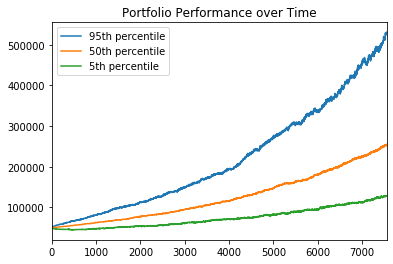

In [457]:
ax= nintey_five_df.plot.line(title="Portfolio Performance over Time")

fifty_df.plot(ax=ax)
five_df.plot(ax=ax)